In [1077]:
import ipywidgets as widgets
from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

warnings.filterwarnings('ignore')

# Modeling Incidence

In this notebook we present modeling of  two metrics of cancer incidence number of tumors located **insitu** per 1000 of totally diagnozed tumors (insitu means that abnormal cells have been found in their place of origin but have not spread to nearby tissues). And number of diagnozed **multiple tumors** per 1000 cases

The following model must reflect ongoing reforms in Ukrainian medical system as well as COVID19 outbreak and full-scale invasion in 2022

In [1078]:
st_df = pd.read_csv('./final_dataset/stage_incidence_features.csv')

In [1079]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      336 non-null    int64  
 1   region                    336 non-null    object 
 2   mtumors                   336 non-null    float64
 3   syncmtumors               336 non-null    float64
 4   insitu                    336 non-null    float64
 5   ncervix                   336 non-null    float64
 6   nhospotal_pht             336 non-null    float64
 7   nbeds_pht                 336 non-null    float64
 8   ybeds_pht                 336 non-null    float64
 9   nill_pht                  336 non-null    float64
 10  nvillage_ill_pht          336 non-null    float64
 11  bed_days_pht              336 non-null    float64
 12  dvisits_pht               336 non-null    float64
 13  hvisits_pht               336 non-null    float64
 14  ndoctors_p

In [1080]:
st_df = st_df.drop(columns=['tincidence_pht', 'mtumors', 'syncmtumors', 'insitu', 'ncervix', 'nvillage_ill_pht',
                            'hvisits_pht', 'ndialysis_pht', 'ndialysis_pht', 'nbacter_pht', 'polluted_dumps', 
                            'not_cleaned_dumps', 'dumps_not_cleaned_enough', 'num_clearing_plants', 'nphysic_pht'])

In [1081]:
st_df.columns

Index(['year', 'region', 'nhospotal_pht', 'nbeds_pht', 'ybeds_pht', 'nill_pht',
       'bed_days_pht', 'dvisits_pht', 'ndoctors_pht', 'nnursing_pht',
       'nx_ray_pht', 'nflurography_pht', 'nradiology_pht', 'nradlab_pht',
       'nсt_pht', 'ncardiogram_pht', 'ndiaglab_pht', 'nbiochem_pht',
       'ncyto_pht', 'nimun_pht', 'nendoscop_pht', 'nultrasound_pht',
       'air_pollution', 'cpi', 'population', 'mtumors_pht', 'syncmtumors_pht',
       'insitu_pht', 'insitu_pti', 'mtumors_pti', 'gdp', 'aging_level',
       'mean_age'],
      dtype='object')

## Events that need to be accounted

1. **2012** - start of reorganization of medical system
2. **2014** - moratorium on reargonization to same existing medical system at the start of the war
3. **2015** - withdrawal of the moratorium 
4. **2017** - **2018** - creation of medical districts
5. **2018** - creation of National Health Service of Ukraine
6. **2020** - out break
7. **2022** - start of full-scale invasion

To model these events variables **reorg**, **morat**, **mdistrict**, **nhsu**, **cov**, **inv** will be added. 
Also interaction varables must be added

In [1082]:
st_df['reorg'] = ((st_df.year >= 2012) & (st_df.year < 2014)).astype(int)
# st_df['morat'] = ((st_df.year >= 2014) & (st_df.year < 2015)).astype(int)
st_df['inner'] = ((st_df.year >= 2014) & (st_df.year < 2018)).astype(int)
st_df['nhsu'] = ((st_df.year >= 2018) & (st_df.year < 2019)).astype(int)
st_df['cov'] = ((st_df.year >= 2020) & (st_df.year < 2022)).astype(int)
st_df['inv'] = (st_df.year >= 2022).astype(int)

In [1083]:

equipment_variables = [
    'nhospotal_pht', 'nbeds_pht', 'nx_ray_pht', 'nflurography_pht',
    'nradiology_pht', 'nradlab_pht', 'nсt_pht', 'ncardiogram_pht', 'ndiaglab_pht',
    'nbiochem_pht', 'ncyto_pht', 'nimun_pht', 'nendoscop_pht', 'nultrasound_pht',
]

personnel_variables = ['ndoctors_pht', 'nnursing_pht']

illness_variables = ['nill_pht']

environmental_variables = [
    'air_pollution'
]

dummies = ['reorg', 'inner', 'nhsu', 'cov']

economic_variables = ["gdp", "mean_age"]

all_explanatory_variables = equipment_variables + personnel_variables + illness_variables + environmental_variables + economic_variables

all_dependent_variables = ['mtumors_pti']

Also interaction terms must be added

1. Equipment variables must have interaction with **reorg**, **mdistrict**, **nhsu**
2. Personnel varaibles must have interaction with **reorg**, **mdistrict**, **nhsu**, **cov**, **inv**
3. Illness variables must have interaction with **reorg**, **mdistrict**, **nhsu**, **cov**, **inv** 


In [1084]:
def add_interactions(df, interactions: list[str], x_names: list[str]):
    interaction_names = []
    for interaction in interactions:
        for x_name in x_names:
            interaction_name = f"{interaction}_{x_name}"
            df[interaction_name] = df[interaction] * df[x_name]
            interaction_names.append(interaction_name)
    return df, interaction_names 

# st_df, _ = add_interactions(st_df, ['reorg', "morat", 'inner', 'mdistrict', 'nhsu', 'cov'], equipment_variables)
# st_df, _ = add_interactions(st_df, ['reorg', "morat", 'inner', 'mdistrict', 'nhsu', 'cov'], personnel_variables)
# st_df, _ = add_interactions(st_df, ['reorg', "morat", 'inner', 'mdistrict', 'nhsu', 'cov'], illness_variables)

## Trend account

In [1085]:
st_df['t'] = st_df['year'] - 2008

In [1086]:

def coupled_detrend(df: pd.DataFrame, x_names: list[str]):
    df = df.copy()
    years = sorted(df.year.unique())
    for x_name in x_names:
        for year in years:
            x_at_year = df[df.year == year][x_name]
            df.loc[df.year == year, x_name] = x_at_year - x_at_year.mean()
    
    return df


## Quick fixes

In [1087]:
st_df = st_df[st_df.year < 2020]
st_df = st_df[~st_df.region.isin(['Донецька', 'Луганська'])]

## Model selection

In [1088]:
def select_best_model_for(df: pd.DataFrame, target: str, ommit: list[str]) -> tuple[sm.OLS, list[str]]:
    predictors = df.drop(columns=ommit + [target], errors="ignore")

    predictors = predictors.select_dtypes(include=["number"])
    
    X = predictors.copy()
    y = df[target]
    
    X = sm.add_constant(X)
    
    best_model = sm.OLS(y, X).fit()

    best_aic = np.inf

    to_drop = None

    while len(X.columns) > 0:
        aic_not_changed = True
            
        for col in X.columns:
            temp_X = X.drop(col, axis = 1)
            temp_model = sm.OLS(y, temp_X).fit()
            if temp_model.aic < best_aic:
                best_aic = temp_model.aic
                best_model = temp_model
                to_drop = col
                aic_not_changed = False

        if aic_not_changed:
            break

        X = X.drop(to_drop, axis = 1)
    
    return best_model



In [1089]:
ommit = ["age_group", "year", "region", "category",  'mtumors_pht', 'syncmtumors_pht',
         'insitu_pht', 'insitu_pti', 'mtumors_pti', 'ncervix', 'mtumors', 'syncmtumors', 'insitu', 
         'gdp', 'mtumors_pti', 'tincidence', 'cpi', 'ybeds_pht', 'population']

In [1090]:
def get_interpretation_table(params, explanatory_names):
    interpretation_table = {dummy: [] for dummy in ['reorg', 'inner', 'nhsu']}
    interpretation_table.update({"base": None})

    interpretation_table["base"] = [params.get(x_name, 0) for x_name in explanatory_names]

    for dummy in ['reorg', 'inner', 'nhsu']:
        for x_name in explanatory_names:
            total_impact = params.get(x_name, 0) + params.get(f"{dummy}_{x_name}", 0)
            interpretation_table[dummy].append(total_impact)
    return pd.DataFrame(interpretation_table, index=explanatory_names)

In [1091]:
st_df['dvisits_pht'] /= st_df['ndoctors_pht']
st_df['nill_pht'] /= st_df['ndoctors_pht']

st_df['mdevindex'] = (st_df['ndiaglab_pht'] + \
                     st_df['nx_ray_pht'] + \
                     st_df['nflurography_pht'] + \
                     st_df['nultrasound_pht'] + \
                     st_df['nendoscop_pht']) / 5


### Simple model

In [1092]:

quantitative_variables = [
    'dvisits_pht', 'ndoctors_pht','nсt_pht', 'mdevindex'
]

explanatory_variables = quantitative_variables + ['t'] + economic_variables + ['air_pollution']

df = st_df[explanatory_variables + all_dependent_variables + ['year', 'region']]


df = coupled_detrend(df, quantitative_variables)
df['mtumors_pti'] = np.log(df['mtumors_pti'])


mtumors_model = select_best_model_for(df, 'mtumors_pti', ommit)

selected_params = list(mtumors_model.params.keys())
selected_params.remove('const')

print(mtumors_model.summary())

                            OLS Regression Results                            
Dep. Variable:            mtumors_pti   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     89.41
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           2.71e-54
Time:                        01:52:03   Log-Likelihood:                 172.05
No. Observations:                 264   AIC:                            -332.1
Df Residuals:                     258   BIC:                            -310.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.7552      0.179      9.800      

## Tests

In [1093]:
import pandas as pd
import statsmodels.api as sm

X = df[explanatory_variables]  
X = sm.add_constant(X) 

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

        Variable         VIF
0          const  671.746492
1    dvisits_pht    1.391516
2   ndoctors_pht    1.713117
3        nсt_pht    1.092629
4      mdevindex    1.383922
5              t    3.728825
6            gdp    4.299737
7       mean_age    1.425105
8  air_pollution    1.514840


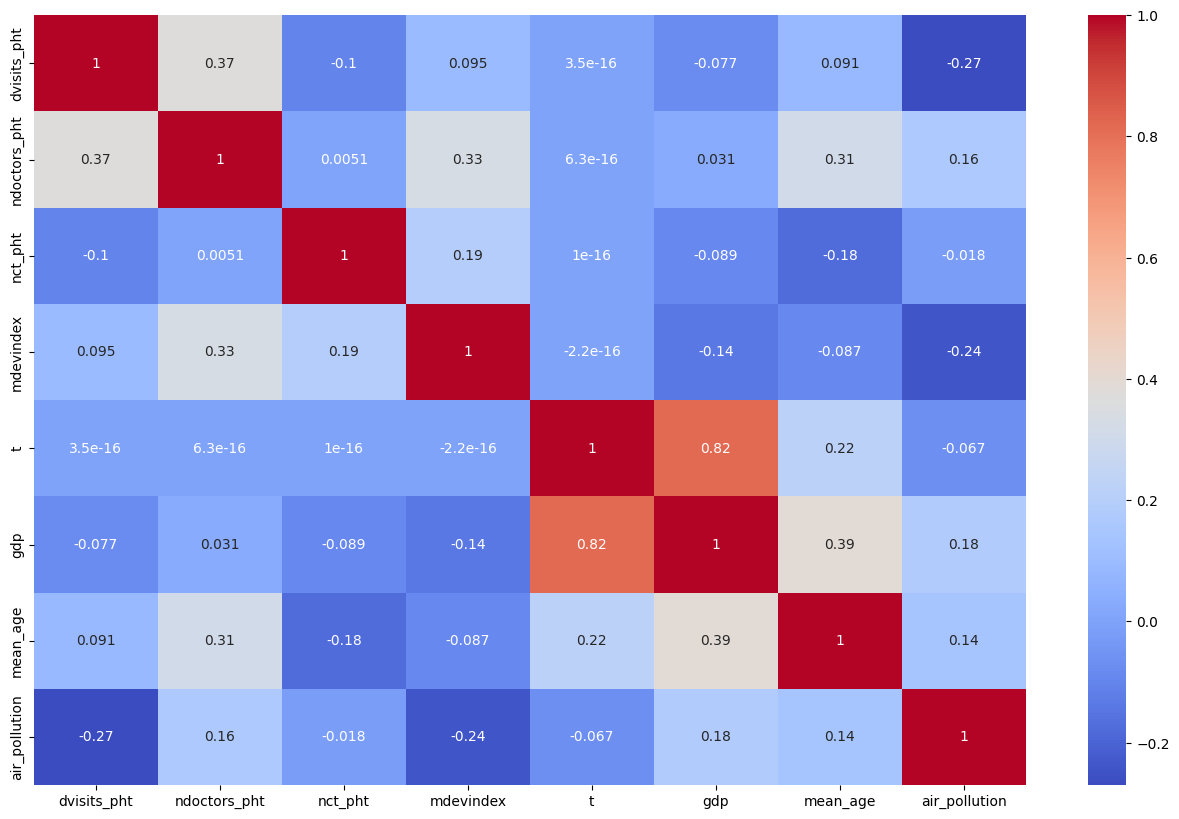

,dvisits_pht,ndoctors_pht,nсt_pht,mdevindex,t,gdp,mean_age,air_pollution
dvisits_pht,1.000000e+00,3.713250e-01,-1.018070e-01,9.484095e-02,3.525277e-16,-0.077494,0.090839,-0.270032
ndoctors_pht,3.713250e-01,1.000000e+00,5.119130e-03,3.323126e-01,6.323968e-16,0.030893,0.306230,0.162392
nсt_pht,-1.018070e-01,5.119130e-03,1.000000e+00,1.930512e-01,1.045494e-16,-0.089191,-0.180487,-0.017831
mdevindex,9.484095e-02,3.323126e-01,1.930512e-01,1.000000e+00,-2.241816e-16,-0.137847,-0.086770,-0.242858
t,3.525277e-16,6.323968e-16,1.045494e-16,-2.241816e-16,1.000000e+00,0.816795,0.216588,-0.067499
gdp,-7.749365e-02,3.089284e-02,-8.919072e-02,-1.378474e-01,8.167952e-01,1.000000,0.394159,0.181006
mean_age,9.083909e-02,3.062301e-01,-1.804874e-01,-8.676959e-02,2.165879e-01,0.394159,1.000000,0.139209
air_pollution,-2.700322e-01,1.623918e-01,-1.783077e-02,-2.428582e-01,-6.749922e-02,0.181006,0.139209,1.000000


In [1094]:
plt.figure(figsize=(16, 10))
correlation_matrix = df[explanatory_variables].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()
correlation_matrix


## Serial correlation

In [1095]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(mtumors_model.resid)
print(dw_stat)

2.023386937633195


## Heteroskedastisity

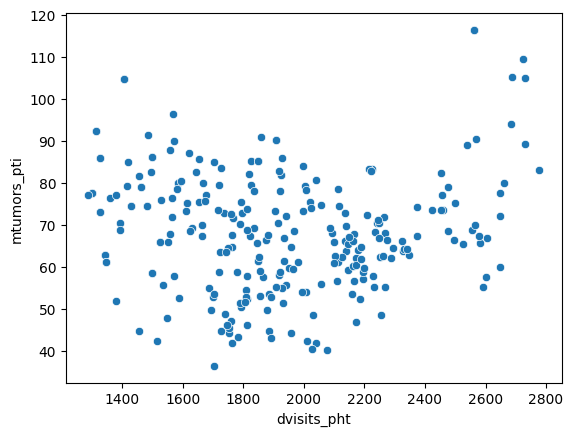

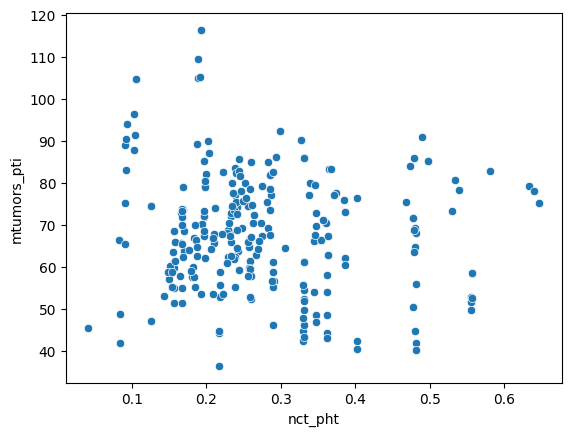

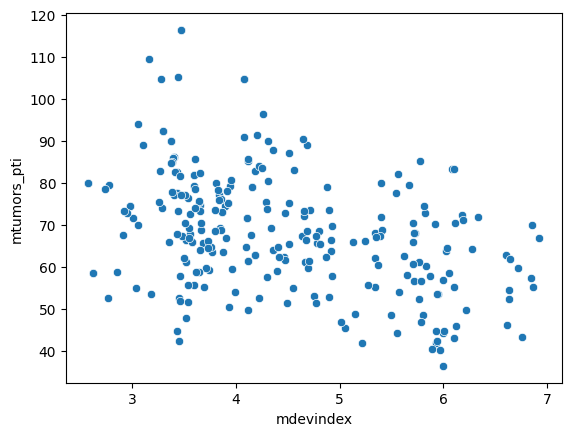

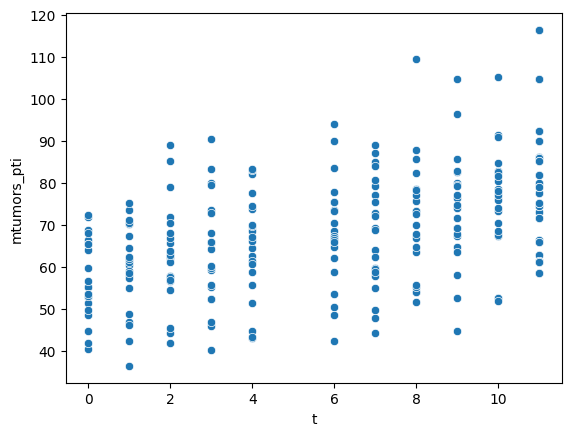

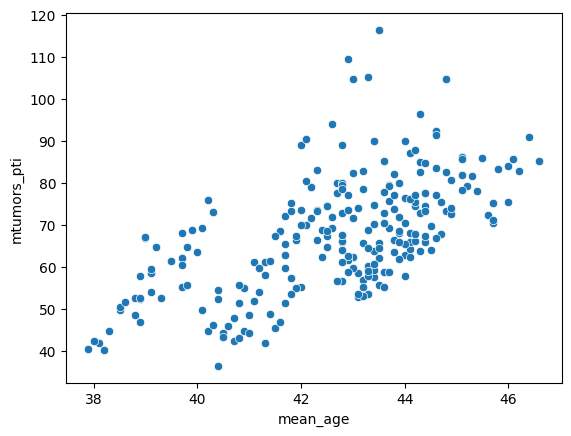

In [1096]:
for x_name in selected_params:
    sns.scatterplot(st_df, y='mtumors_pti', x=x_name)
    plt.show()

In [1104]:
from statsmodels.stats.diagnostic import het_breuschpagan

X = sm.add_constant(st_df[selected_params])
y = np.log(st_df['mtumors_pti'])

model = sm.OLS(y, X).fit()


bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': np.float64(17.49797575753909), 'LM-Test p-value': np.float64(0.0036460780397767033), 'F-Statistic': np.float64(3.662832189162567), 'F-Test p-value': np.float64(0.0032140568665343355)}


In [1098]:

X = sm.add_constant(st_df[selected_params])
y = st_df['mtumors_pti']

model = sm.OLS(y, X).fit()

resid_squared = model.resid ** 2

for col in X.columns:
    if col == 'const':
        continue
    aux_X = sm.add_constant(X[[col]])
    aux_model = sm.OLS(resid_squared, aux_X).fit()
    print(f'{col}: p-value = {aux_model.pvalues[col]}')


dvisits_pht: p-value = 0.3838813510465927
nсt_pht: p-value = 4.0142181443552155e-05
mdevindex: p-value = 0.029047116306435892
t: p-value = 0.004238361666007191
mean_age: p-value = 0.21736133816408712


In [1099]:
model_robust = mtumors_model.get_robustcov_results(cov_type='HC3')
print(model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:            mtumors_pti   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     88.86
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           4.48e-54
Time:                        01:52:04   Log-Likelihood:                 172.05
No. Observations:                 264   AIC:                            -332.1
Df Residuals:                     258   BIC:                            -310.6
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.7552      0.156     11.238      